In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scripts.oso_db import execute_query, query_and_dump_to_csv
from visualizations.contribution_heatmap import contribution_heatmap
from visualizations.stacked_area import activity_plot, EVENT_TYPES

In [2]:
query = """
    SELECT
        p."name" AS project_name,
        a."name" AS github_repo,
        e."fromId" AS contributor_id,
        e."type" AS event_type,
        e."id" AS event_id,
        e."time" AS event_time
    FROM
        project p
    JOIN
        project_artifacts_artifact paa ON p."id" = paa."projectId"
    JOIN
        artifact a ON paa."artifactId" = a."id"
    JOIN
        event e ON a."id" = e."toId"
    WHERE
        a."namespace" = 'GITHUB'
        AND p."slug" = 'gitcoin'
        AND NOT a."name" IN (
            'gitcoinco/mattermost-server',
            'gitcoinco/mattermost-webapp',
            'gitcoinco/mattermost-redux',
            'gitcoinco/mattermost-plugin-gitlab',
            'gitcoinco/django-cacheops',
            'gitcoinco/contract-metadata',
            'gitcoinco/discourse-adplugin',
            'gitcoinco/slack-protector',
            'gitcoinco/snapshot-spaces',
            'gitcoinco/sourcecred',
            'gitcoinco/cred',
            'gitcoinco/code_fund_ads',
            'gitcoinco/EIPs',
            'gitcoinco/codefund',
            'gitcoinco/lemonade-stand',
            'gitcoinco/coz-slack-ico-management-platform',
            'gitcoinco/desktop-app'
        )
"""

result = execute_query(query, col_names=True)
df = pd.DataFrame(result[1:], columns=result[0])
df['date'] = df['event_time'].apply(lambda x: x.date())
df['month'] = pd.PeriodIndex(df.event_time, freq='M')
df['quarter'] = pd.PeriodIndex(df.event_time, freq='Q')
df.drop(columns=['event_time'], inplace=True)
df

project_name                  github_repo  contributor_id  \
0          Gitcoin       gitcoinco/grants-stack         35127.0   
1          Gitcoin       gitcoinco/grants-stack         35127.0   
2          Gitcoin           allo-protocol/docs         34082.0   
3          Gitcoin        allo-protocol/allo-v2         35799.0   
4          Gitcoin           allo-protocol/docs         50223.0   
...            ...                          ...             ...   
78627      Gitcoin  gitcoinco/Gitcoin-Exemplars         33251.0   
78628      Gitcoin  gitcoinco/Gitcoin-Exemplars         33251.0   
78629      Gitcoin  gitcoinco/Gitcoin-Exemplars         33251.0   
78630      Gitcoin  gitcoinco/Gitcoin-Exemplars         33251.0   
78631      Gitcoin  gitcoinco/Gitcoin-Exemplars         33251.0   

                event_type  event_id        date    month quarter  
0      PULL_REQUEST_MERGED  11269900  2023-10-12  2023-10  2023Q4  
1      PULL_REQUEST_CLOSED  11269914  2023-10-12  2023-10  2023Q4  
2      PULL_REQUEST_CLOSED  11269915  2023-10-12  2023-10  2023Q4  
3      PULL_REQUEST_CLOSED  11269913  2023-10-12  2023-10  2023Q4  
4      PULL_REQUEST_MERGED  11269901  2023-10-12  2023-10  2023Q4  
...                    ...       ...         ...      ...     ...  
78627          COMMIT_CODE   5487647  2018-09-24  2018-09  2018Q3  
78628          COMMIT_CODE   5487648  2018-09-24  2018-09  2018Q3  
78629          COMMIT_CODE   5487649  2018-09-24  2018-09  2018Q3  
78630          COMMIT_CODE   5487650  2018-09-24  2018-09  2018Q3  
78631          COMMIT_CODE   5487651  2018-09-24  2018-09  2018Q3  

[78632 rows x 8 columns]

In [3]:
len(df[df['event_type'] == 'COMMIT_CODE'])

18032

In [4]:
len(df[df['event_type'] == 'COMMIT_CODE']['contributor_id'].unique())

192

In [5]:
len(df['github_repo'].unique())

119

In [7]:
contrib_counts = df[df.event_type.isin(EVENT_TYPES)]['contributor_id'].value_counts()
filtered_contribs = contrib_counts[contrib_counts>10].index

repo_star_counts = df[df.event_type == 'STARRED'].groupby('github_repo')['event_id'].count()
repo_commit_counts = df[df.event_type == 'COMMIT_CODE'].groupby('github_repo')['event_id'].count()
filtered_repos = set(repo_star_counts[repo_star_counts>1].index).union(set(repo_commit_counts[repo_commit_counts>1].index))

dff = df[df['github_repo'].isin(filtered_repos) * df['contributor_id'].isin(filtered_contribs)]

dff

project_name                  github_repo  contributor_id  \
0          Gitcoin       gitcoinco/grants-stack         35127.0   
1          Gitcoin       gitcoinco/grants-stack         35127.0   
2          Gitcoin           allo-protocol/docs         34082.0   
3          Gitcoin        allo-protocol/allo-v2         35799.0   
4          Gitcoin           allo-protocol/docs         50223.0   
...            ...                          ...             ...   
78627      Gitcoin  gitcoinco/Gitcoin-Exemplars         33251.0   
78628      Gitcoin  gitcoinco/Gitcoin-Exemplars         33251.0   
78629      Gitcoin  gitcoinco/Gitcoin-Exemplars         33251.0   
78630      Gitcoin  gitcoinco/Gitcoin-Exemplars         33251.0   
78631      Gitcoin  gitcoinco/Gitcoin-Exemplars         33251.0   

                event_type  event_id        date    month quarter  
0      PULL_REQUEST_MERGED  11269900  2023-10-12  2023-10  2023Q4  
1      PULL_REQUEST_CLOSED  11269914  2023-10-12  2023-10  2023Q4  
2      PULL_REQUEST_CLOSED  11269915  2023-10-12  2023-10  2023Q4  
3      PULL_REQUEST_CLOSED  11269913  2023-10-12  2023-10  2023Q4  
4      PULL_REQUEST_MERGED  11269901  2023-10-12  2023-10  2023Q4  
...                    ...       ...         ...      ...     ...  
78627          COMMIT_CODE   5487647  2018-09-24  2018-09  2018Q3  
78628          COMMIT_CODE   5487648  2018-09-24  2018-09  2018Q3  
78629          COMMIT_CODE   5487649  2018-09-24  2018-09  2018Q3  
78630          COMMIT_CODE   5487650  2018-09-24  2018-09  2018Q3  
78631          COMMIT_CODE   5487651  2018-09-24  2018-09  2018Q3  

[67330 rows x 8 columns]

(<Figure size 3000x1500 with 1 Axes>,
 <AxesSubplot:ylabel='Monthly Active Contributors'>)

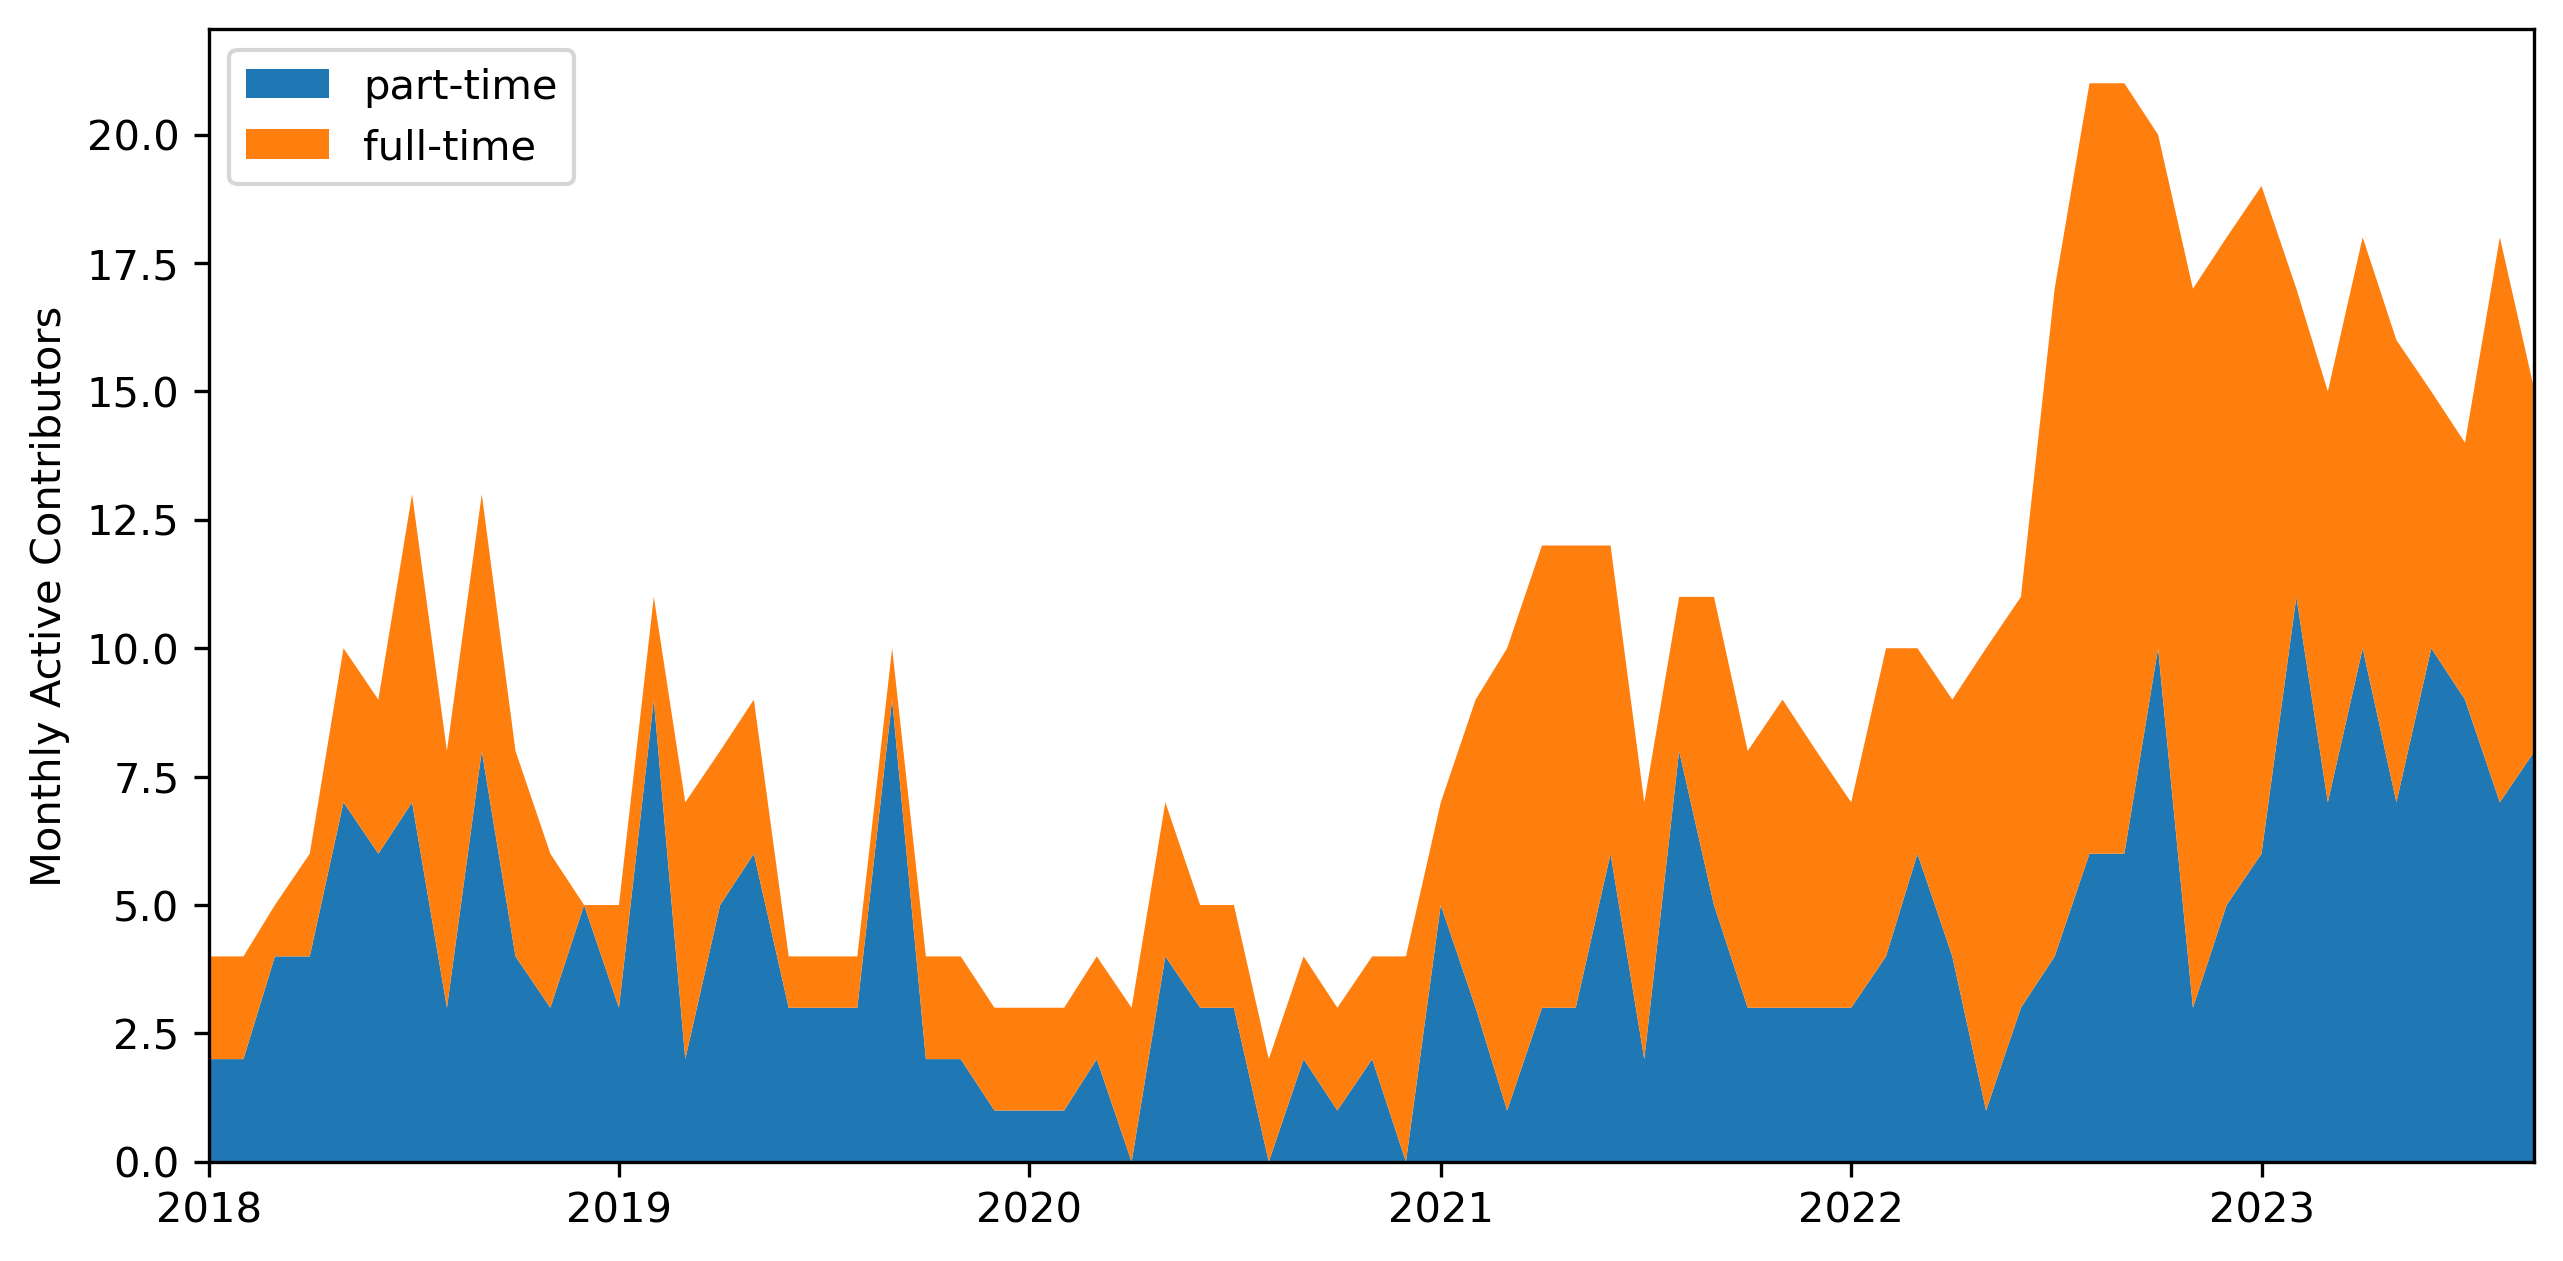

In [8]:
df_contrib_counts = (dff[dff.event_type.isin(['COMMIT_CODE'])]
 .groupby(['month', 'contributor_id'])['event_id']
 .count().rename('contributions')
 .reset_index())

fulltime_threshold = 10
df_contrib_counts['dev_type'] = df_contrib_counts['contributions'].apply(lambda x: 'full-time' if x > fulltime_threshold else 'part-time')
df_contrib_counts['dev_type']
df_contrib_counts['devs'] = 1

activity_plot(
    df_contrib_counts,
    'dev_type',
    date_col='month',
    value_col='devs',
    filter_col='dev_type',
    filter_vals=['full-time', 'part-time'],
    ylabel='Monthly Active Contributors',
    start_date='2018-01-01',
    end_date='2023-08-31',
)

(<Figure size 3000x1500 with 1 Axes>,
 <AxesSubplot:ylabel='Monthly Active Contributors'>)

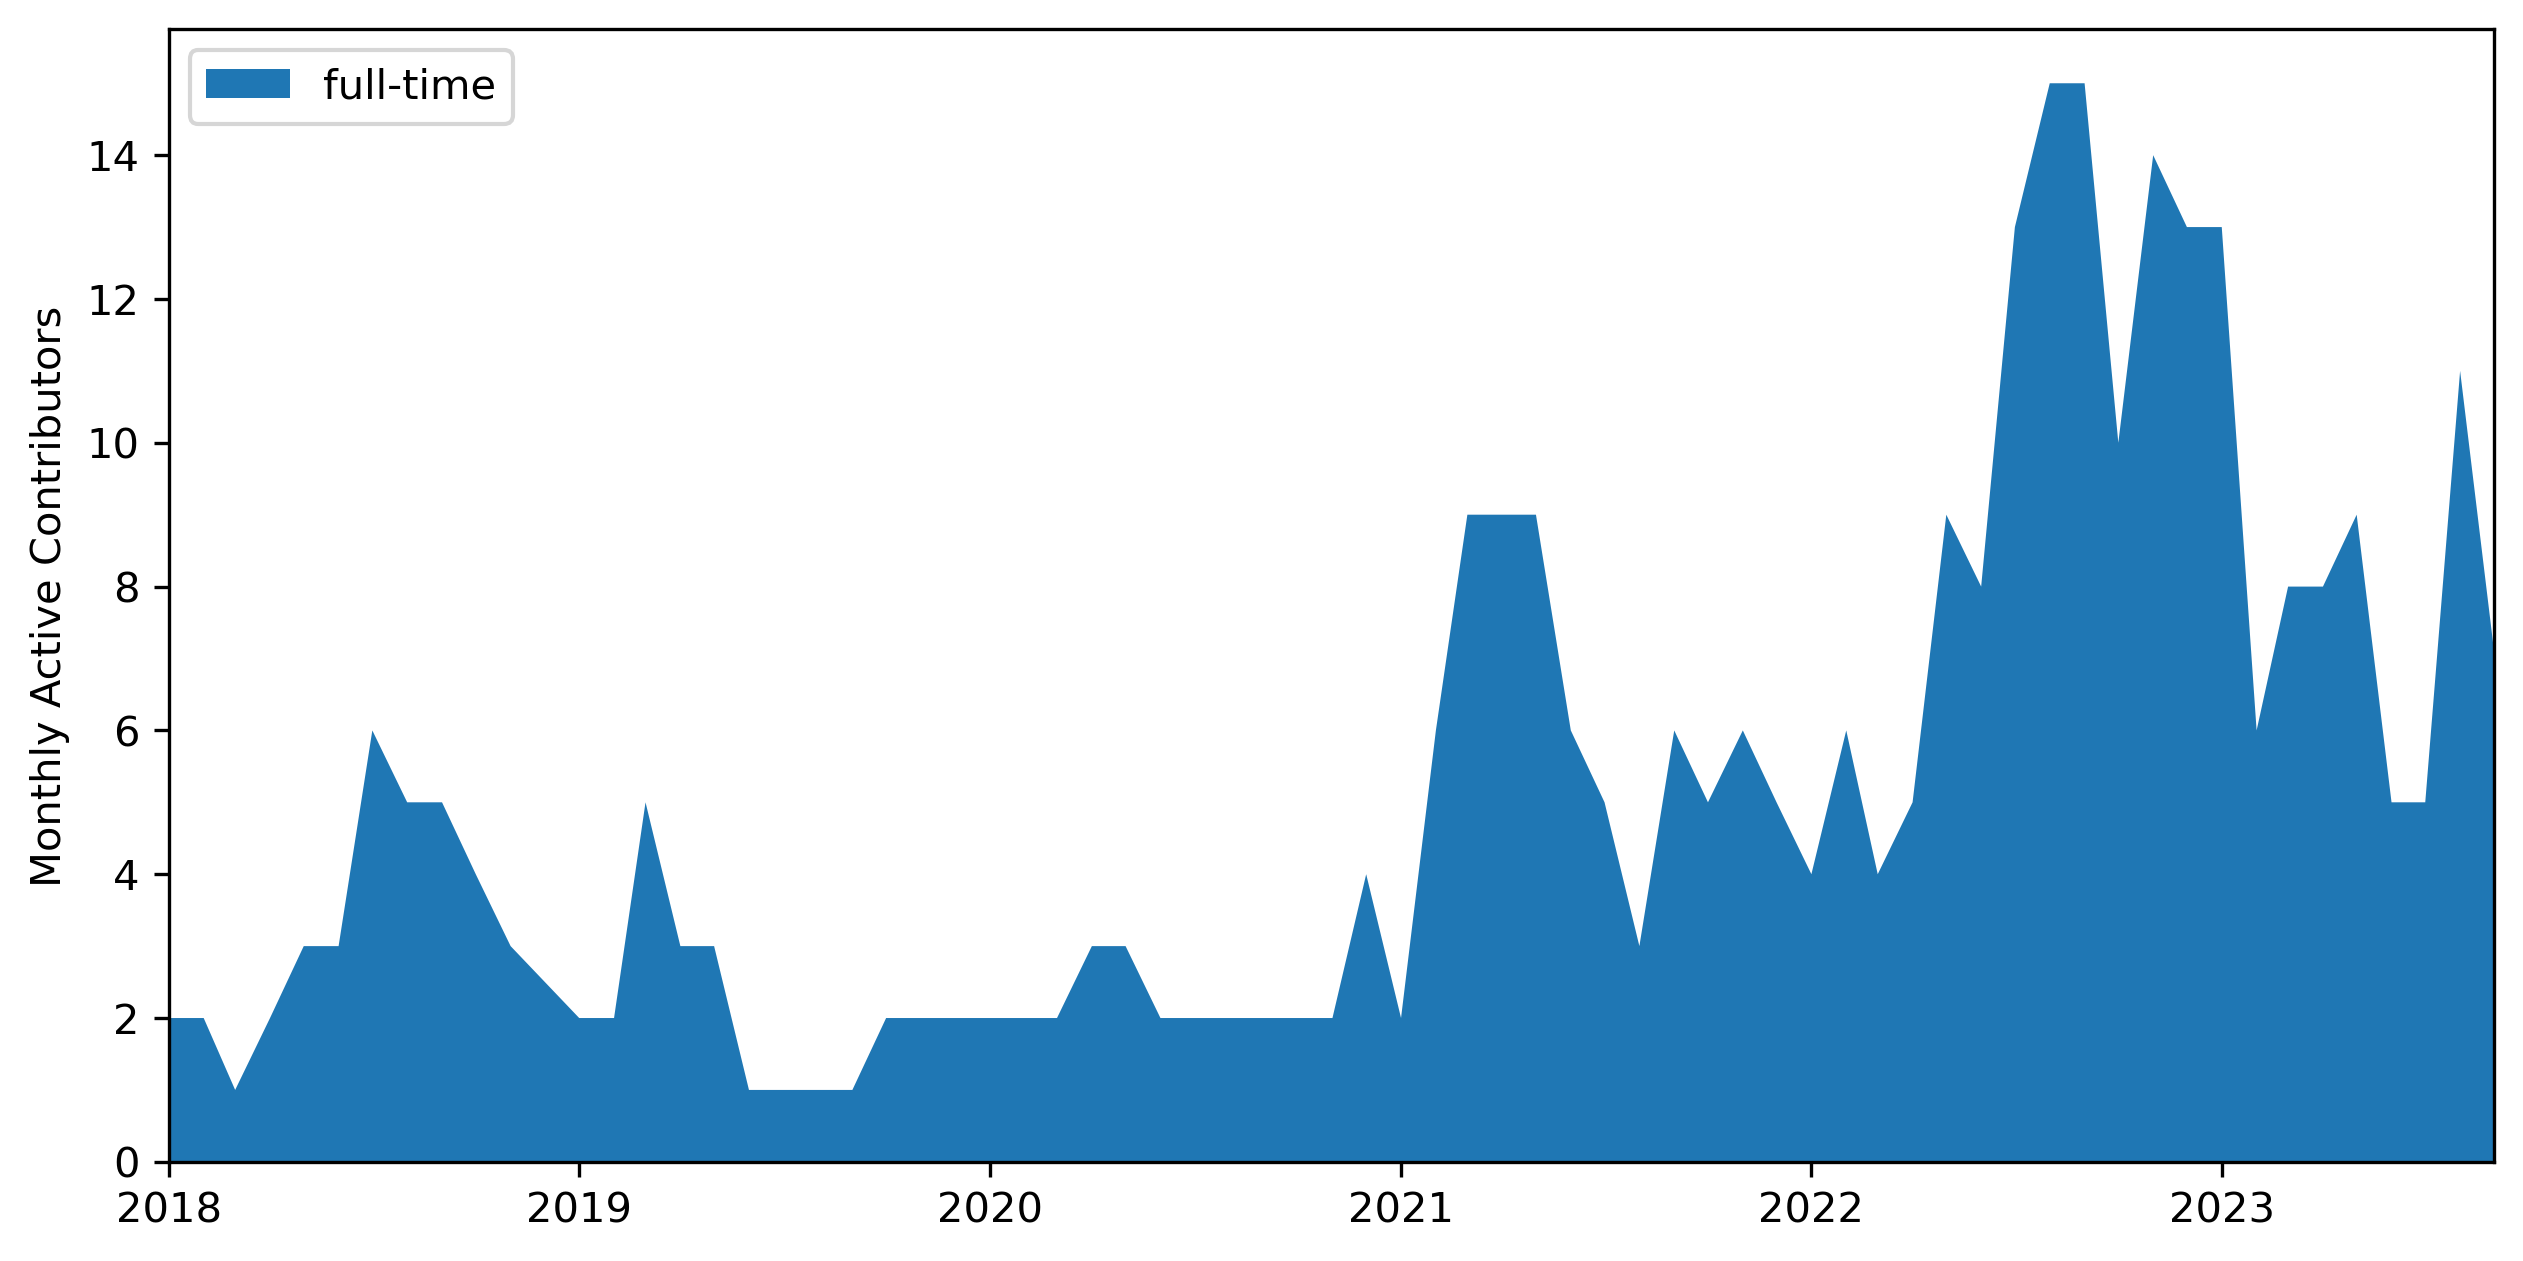

In [9]:
activity_plot(
    df_contrib_counts,
    'dev_type',
    date_col='month',
    value_col='devs',
    filter_col='dev_type',
    filter_vals=['full-time'],
    ylabel='Monthly Active Contributors',
    start_date='2018-01-01',
    end_date='2023-08-31',
)

(<Figure size 3000x1500 with 1 Axes>,
 <AxesSubplot:ylabel='Total Contributions'>)

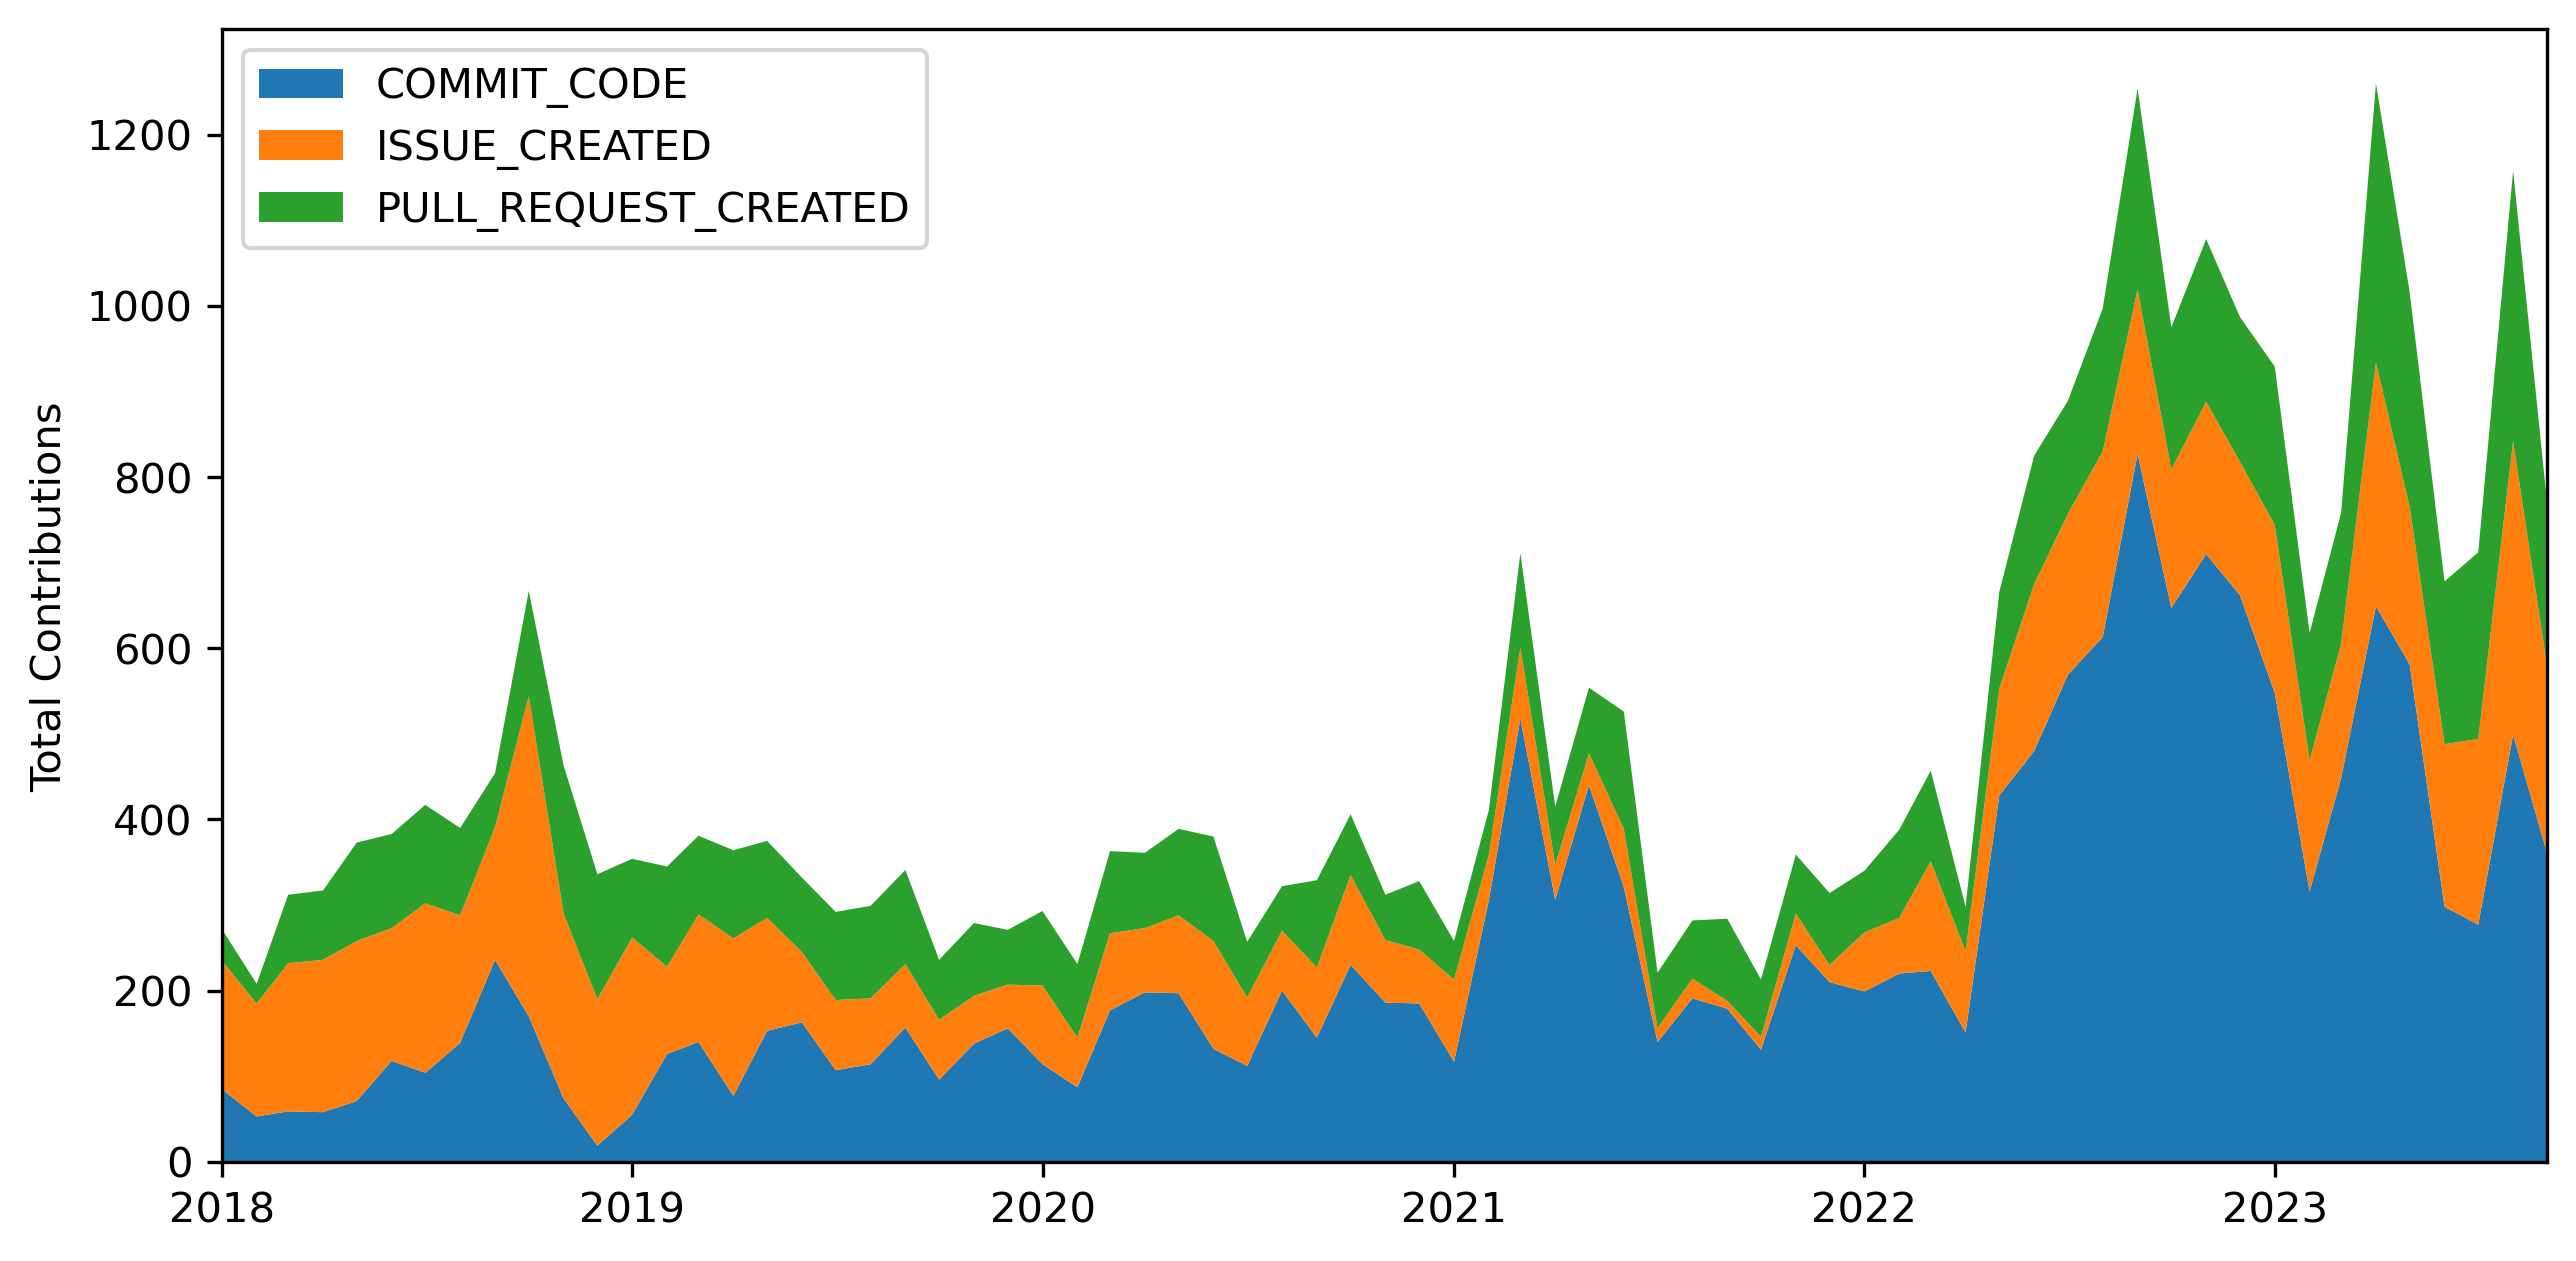

In [10]:
activity_df = dff.copy()
activity_df['num_contributions'] = 1
activity_plot(activity_df, 
              'event_type', 
              date_col='month', 
              start_date='2018-01-01',
              end_date='2023-08-31',
              filter_vals=['COMMIT_CODE', 'PULL_REQUEST_CREATED', 'ISSUE_CREATED'])

(<Figure size 2400x6600 with 1 Axes>, <AxesSubplot:>)

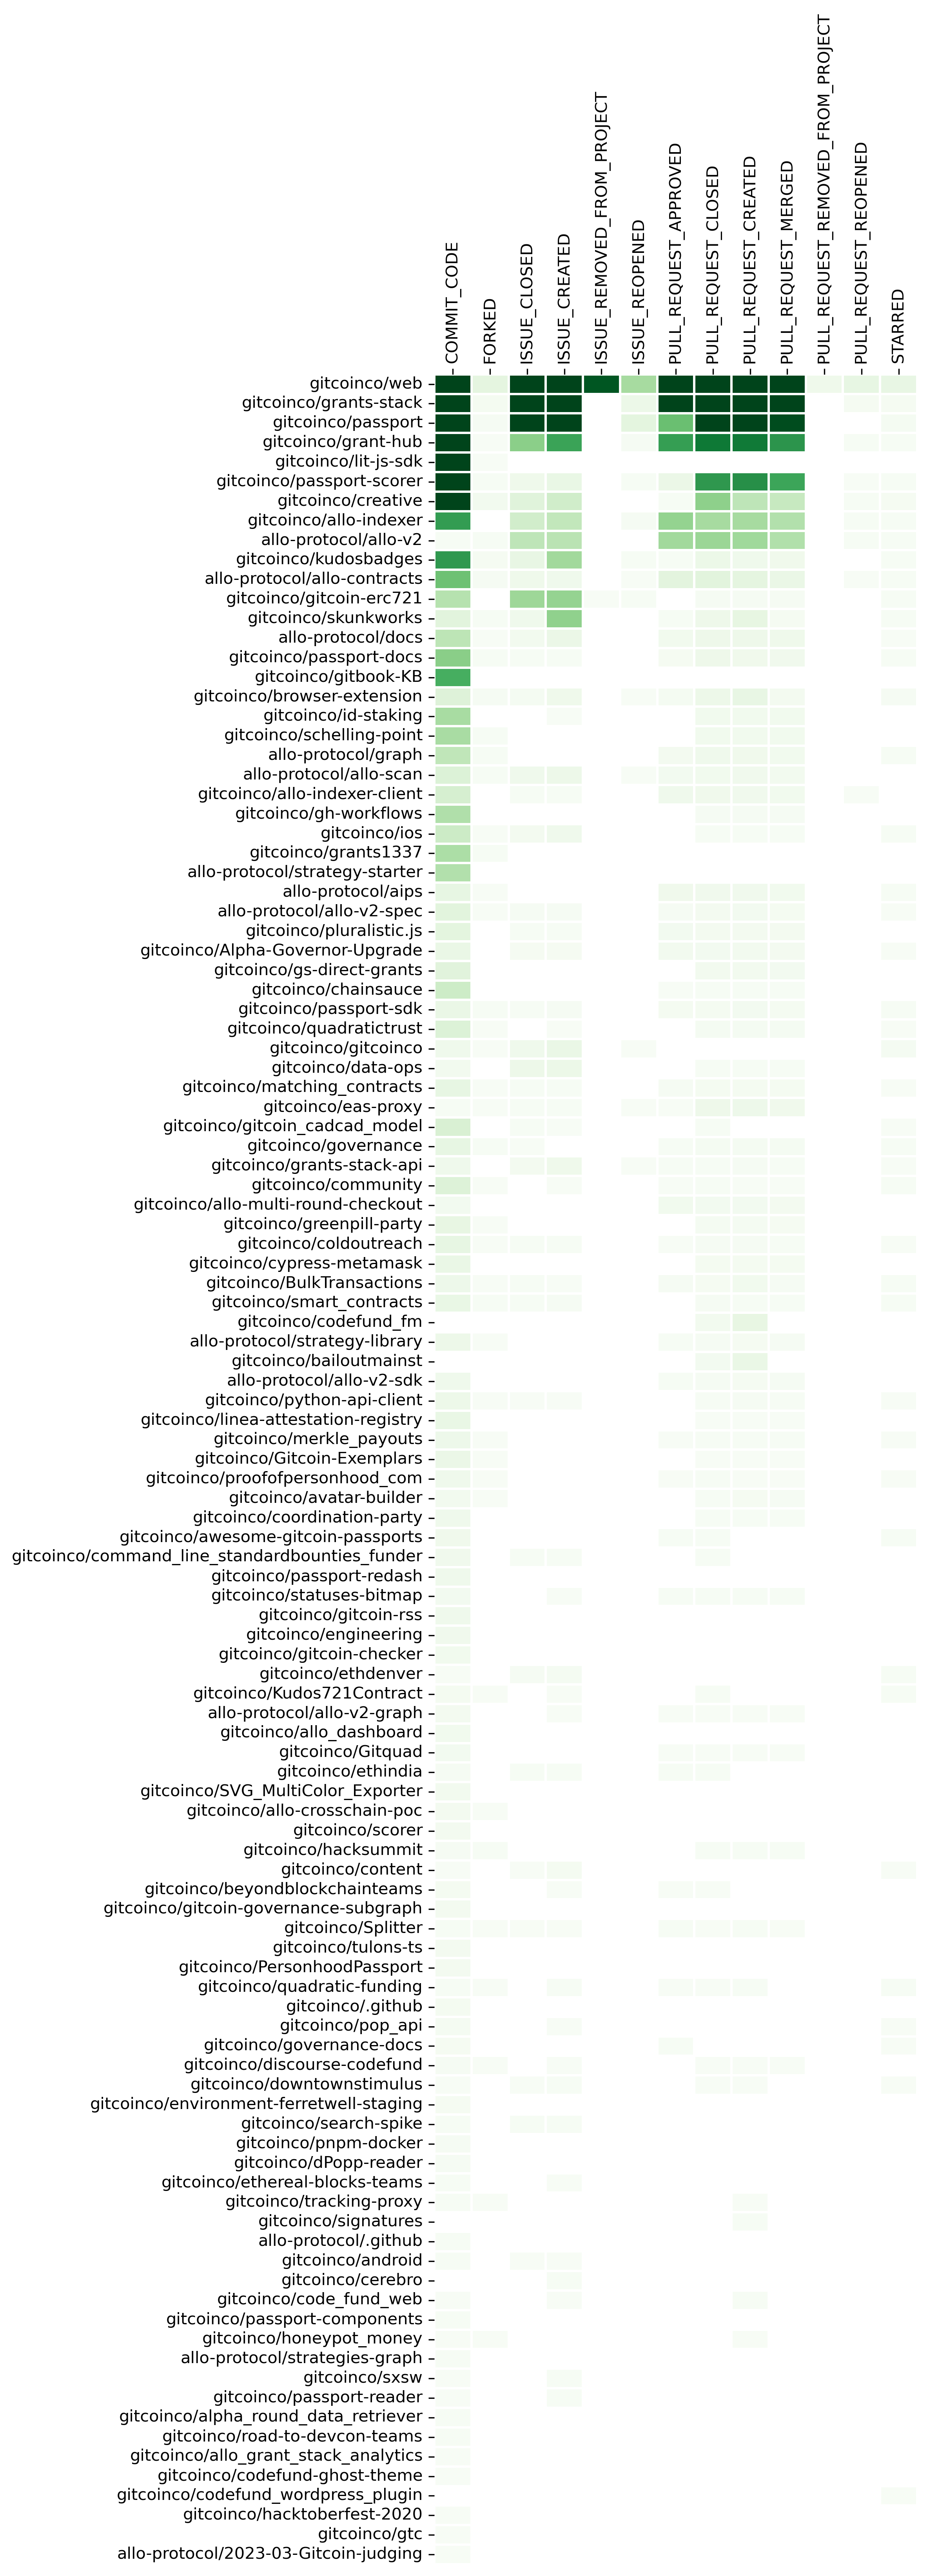

In [11]:
df_activity = (
    dff.groupby(['github_repo', 'event_type'])
    ['event_id'].count()
    .reset_index()
    .rename(columns={'event_id': 'total_contributions'})
)

contribution_heatmap(
    df_activity,
    index_col='github_repo',
    column_col='event_type',
    value_col='total_contributions',
    figsize=(8,22),
    vmax=500,
    sort_label_method='mean'
)

(<Figure size 2400x6600 with 1 Axes>, <AxesSubplot:>)

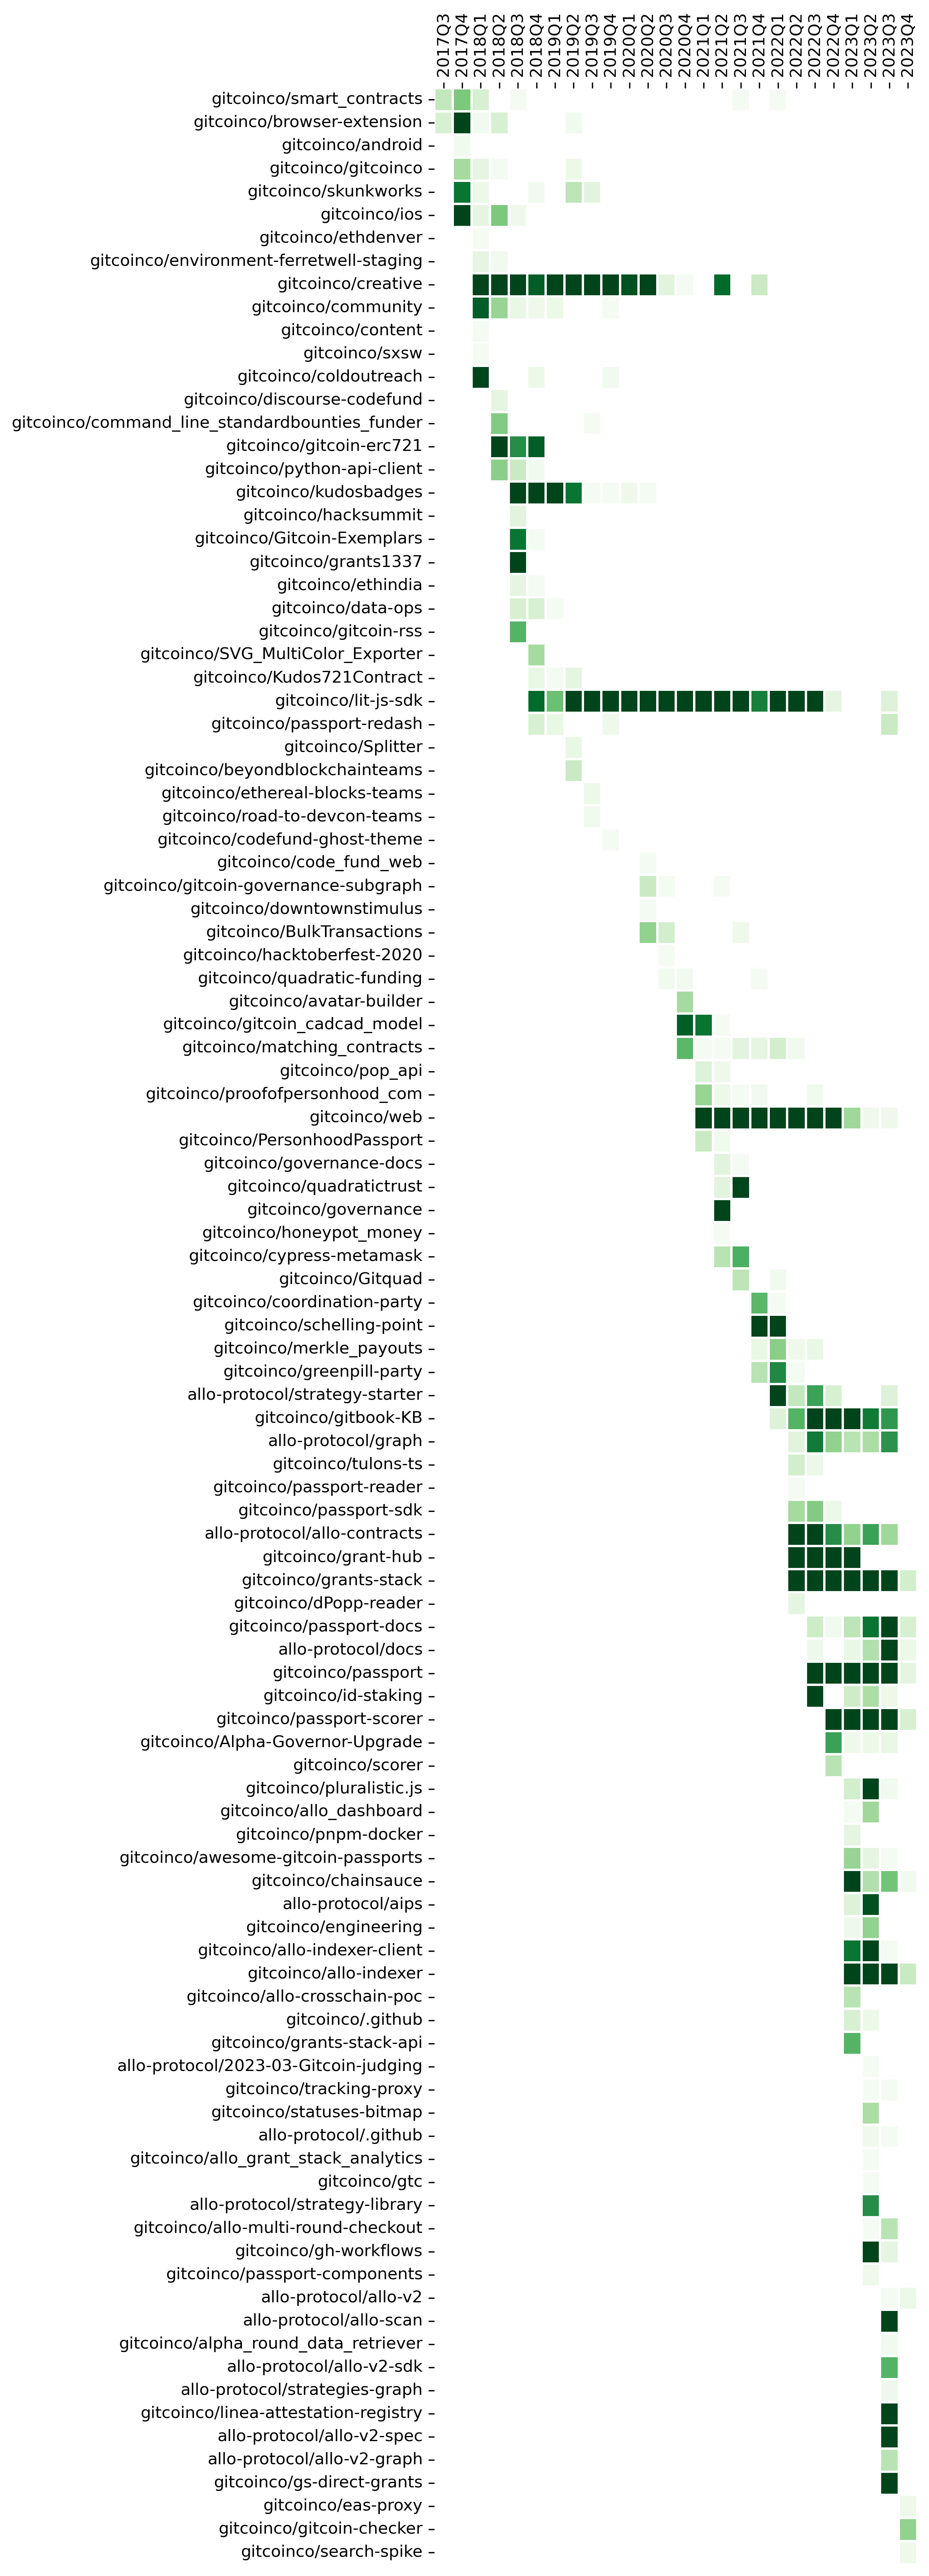

In [12]:
df_commits = (
    dff[dff['event_type']=='COMMIT_CODE']
    .groupby(['github_repo', 'quarter'])
    ['event_id'].count()
    .reset_index()
    .rename(columns={'event_id': 'total_commits'})
)
contribution_heatmap(
    df_commits, 
    index_col='github_repo', 
    column_col='quarter', 
    value_col='total_commits', 
    vmax=50,
    figsize=(8,22)
)

(<Figure size 4320x2640 with 1 Axes>, <AxesSubplot:>)

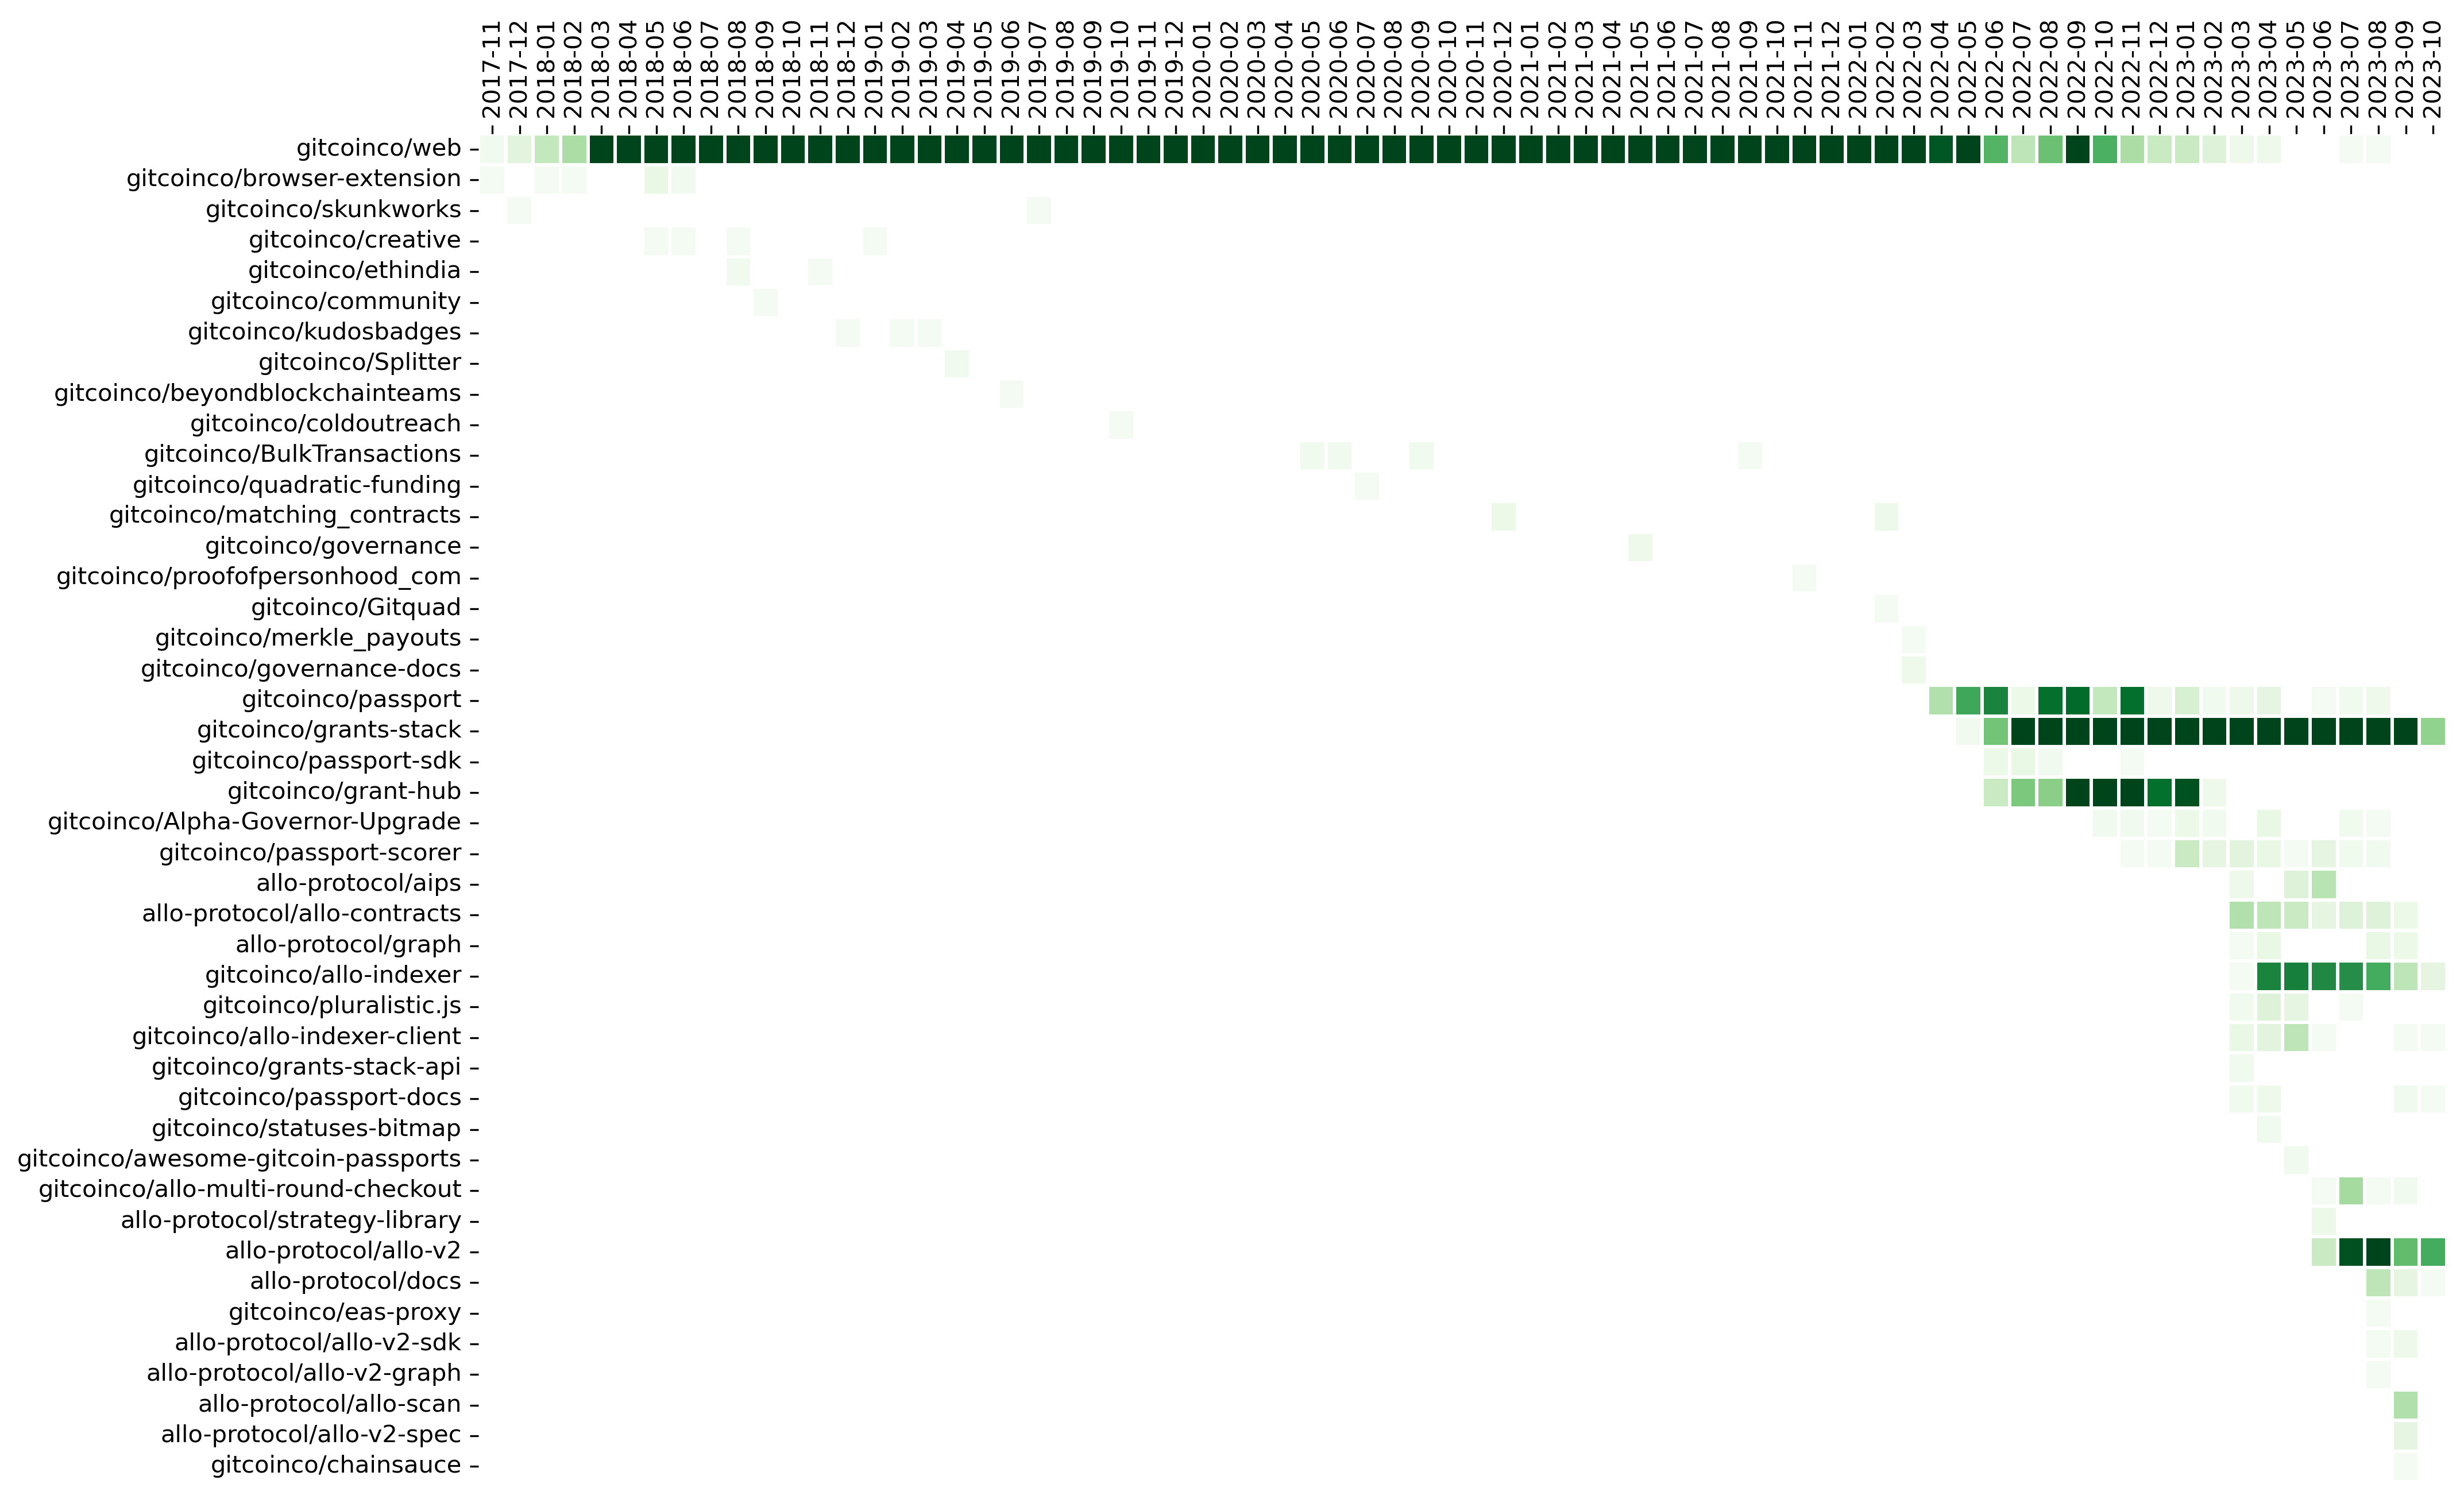

In [13]:
df_prs = (
    dff[dff['event_type']=='PULL_REQUEST_APPROVED']
    .groupby(['github_repo', 'month'])
    ['event_id'].count()
    .reset_index()
    .rename(columns={'event_id': 'total_prs_approved'})
)
contribution_heatmap(
    df_prs, 
    index_col='github_repo', 
    column_col='month', 
    value_col='total_prs_approved', 
    vmax=50,
#    figsize=(8,22)
)

(<Figure size 2400x6600 with 1 Axes>, <AxesSubplot:>)

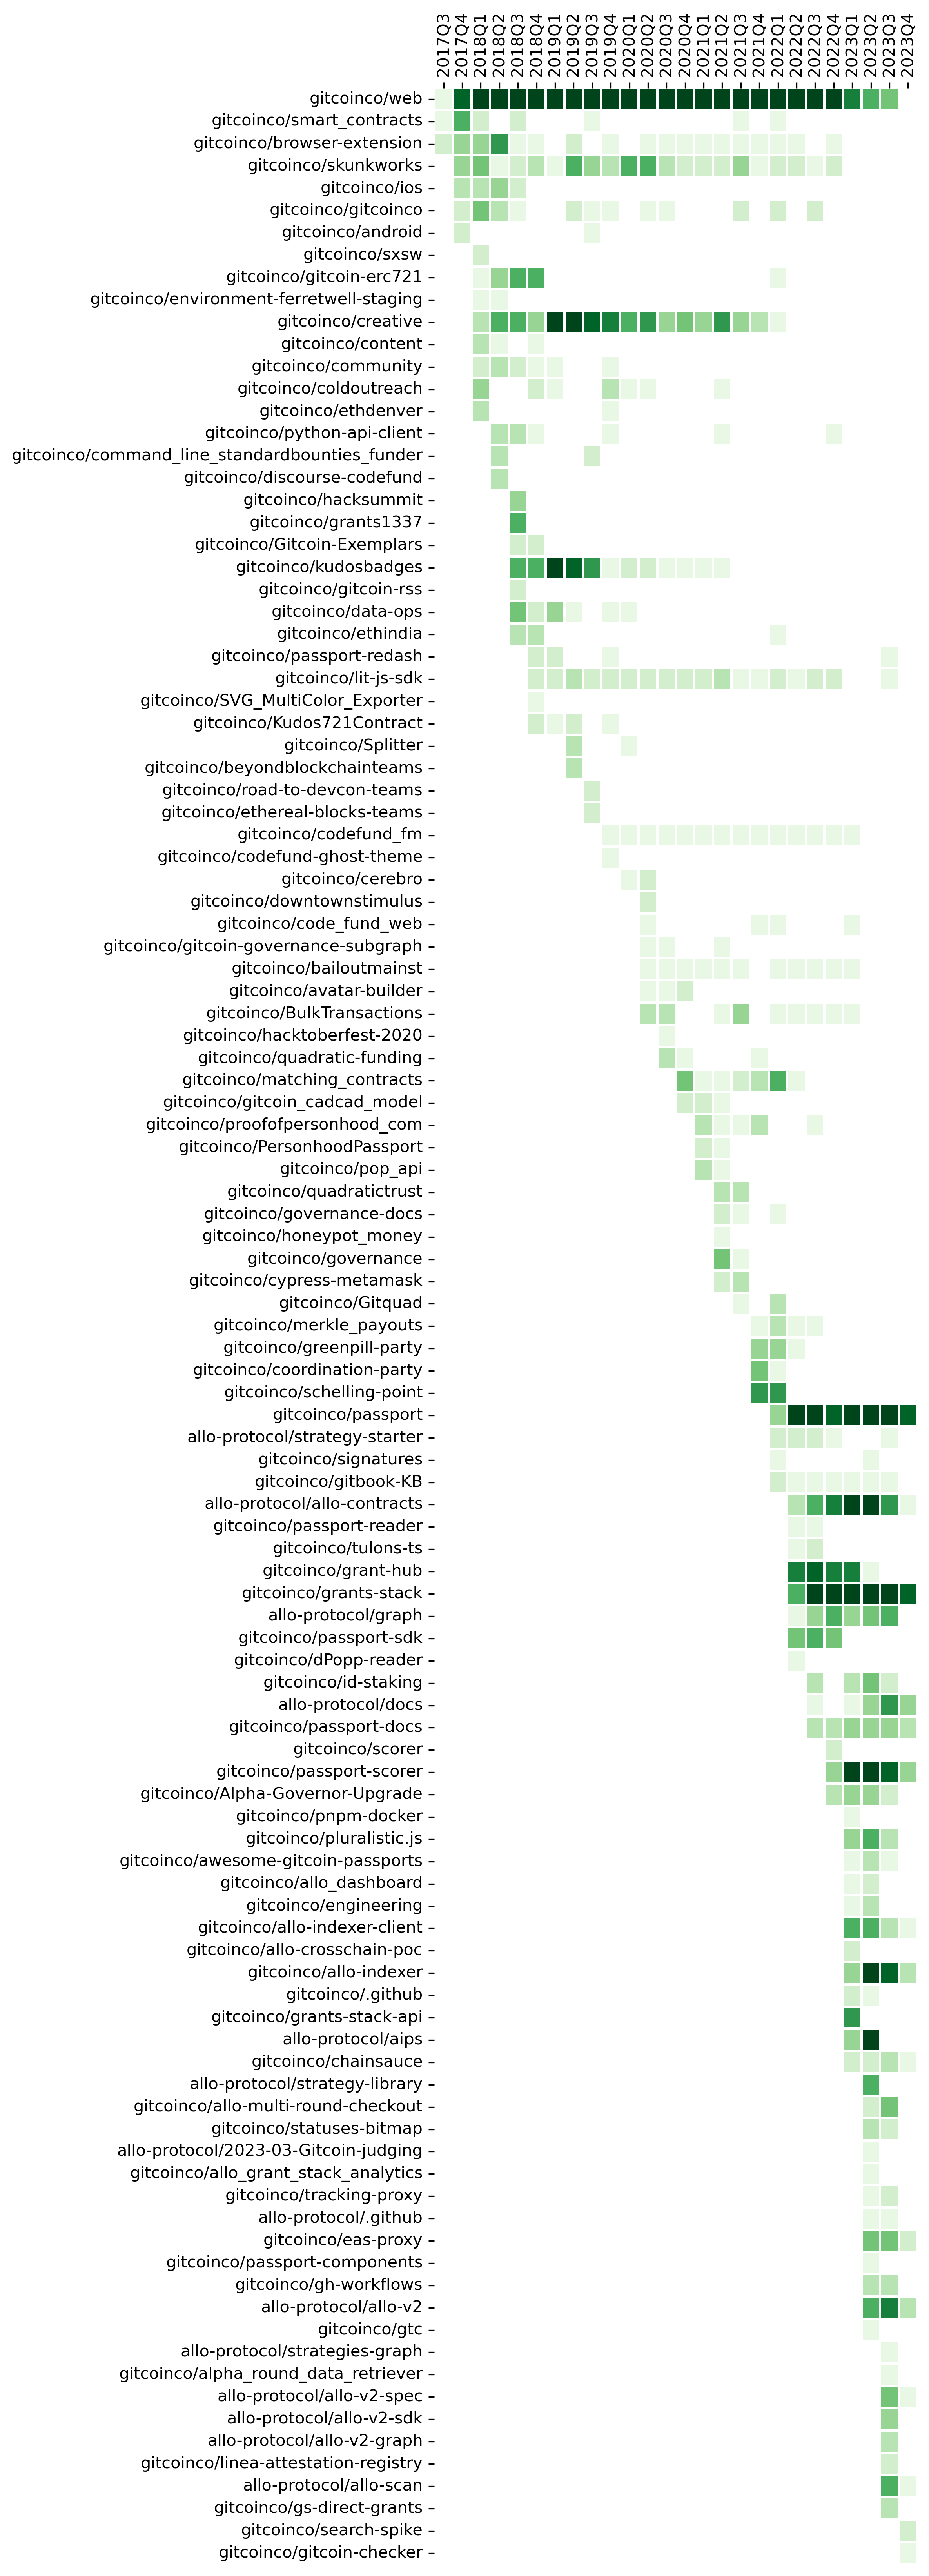

In [14]:
df_contribs = (
    dff[dff['event_type'].isin(EVENT_TYPES)]
    .groupby(['github_repo', 'quarter'])
    ['contributor_id'].nunique()
    .reset_index()
    .rename(columns={'contributor_id': 'total_contributors'})
)
contribution_heatmap(
    df_contribs, 
    index_col='github_repo', 
    column_col='quarter', 
    value_col='total_contributors', 
    vmax=10,
    figsize=(8,22)
)

In [15]:
df[df['event_type'] == 'PULL_REQUEST_APPROVED']['contributor_id'].value_counts().head(20)

contributor_id
35799.0     2209
53636.0      718
203361.0     665
75057.0      557
34880.0      355
38078.0      303
37263.0      253
34082.0      230
35127.0      190
185840.0     184
39285.0      171
36652.0      170
462906.0     166
43970.0      149
36653.0      120
38077.0      119
39286.0      110
47855.0      101
199468.0      99
38079.0       96
Name: count, dtype: int64

In [16]:
df_issues = (
    df[df['event_type'].isin(['ISSUE_CLOSED','ISSUE_CREATED'])]
    .pivot_table(index='contributor_id', columns='event_type', values='event_id', aggfunc='count')
).dropna()
df_issues['NUM_ISSUES'] = df_issues.sum(axis=1)
df_issues.sort_values(by='NUM_ISSUES', ascending=False).head(20)

event_type      ISSUE_CLOSED  ISSUE_CREATED  NUM_ISSUES
contributor_id                                         
35799.0               3536.0          324.0      3860.0
36653.0                635.0         1845.0      2480.0
47855.0                446.0          840.0      1286.0
36652.0                181.0          801.0       982.0
43970.0                330.0          629.0       959.0
75057.0                391.0          350.0       741.0
42368.0                173.0          451.0       624.0
46393.0                152.0          446.0       598.0
39285.0                144.0          274.0       418.0
53636.0                168.0          166.0       334.0
103900.0               199.0          104.0       303.0
35127.0                162.0           64.0       226.0
38079.0                149.0           65.0       214.0
34880.0                132.0           47.0       179.0
77591.0                 84.0           92.0       176.0
104249.0                83.0           86.0       169.0
37263.0                 69.0           98.0       167.0
203361.0               102.0           65.0       167.0
47848.0                 16.0          148.0       164.0
150869.0                67.0           94.0       161.0